In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16

# **Loading the dataset**

In [2]:
batch_size = 32
img_height = 224
img_width = 224

## Mount Google drive

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
# labels_path = "gdrive/MyDrive/peltarion dataset/preprocessed/index.csv"
labels_path = "preprocessed/index.csv"
labels = pd.read_csv(labels_path)

## One hot encoding y values

In [5]:
label_names = labels['class'].unique().tolist()
print(label_names)

y = []

for idx, name in enumerate(labels['class']):
    y.append(label_names.index(name))
    
y[:5]

['unknown', 'head_lamp', 'door_scratch', 'glass_shatter', 'tail_lamp', 'bumper_dent', 'door_dent', 'bumper_scratch']


[0, 1, 2, 1, 0]

## Create train and validation dataset

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     'gdrive/MyDrive/peltarion dataset/preprocessed', 
    'preprocessed',
    labels=y, label_mode='int', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42, 
    validation_split=0.2, subset='training'
)


val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     'gdrive/MyDrive/peltarion dataset/preprocessed', 
    'preprocessed',
    labels=y, label_mode='int', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42, 
    validation_split=0.2, subset='validation'
)

Found 1512 files belonging to 1 classes.
Using 1210 files for training.
Found 1512 files belonging to 1 classes.
Using 302 files for validation.


## Size of the datasets

In [7]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Visualize the dataset

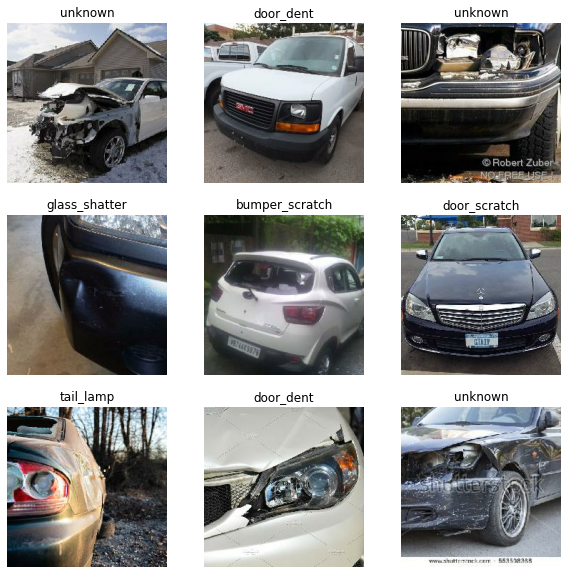

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(label_names[int(labels[i])])
    plt.axis("off")

In [9]:
labels

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 6, 0, 3, 7, 2, 4, 6, 0, 6, 6, 0, 5, 6, 0, 7, 6, 0, 2, 6, 0, 1,
       4, 5, 6, 6, 7, 1, 0, 3, 0, 0])>

## Resize, rescale and augment functions

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  # layers.experimental.preprocessing.Rescaling(1./255)
])

## Augment the dataset, preprocess and optimization functions

In [12]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):

  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  # ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
  
  # preprocess for VGG16
  ds = ds.map(lambda x, y: (preprocess_input(x), y), 
              num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

## Running augment, preprocess and optimization functions on dataset

In [13]:
train_dataset = prepare(train_dataset, shuffle=True, augment=True)
val_dataset = prepare(val_dataset)

## Configure dataset for performance (redundant maybe)

In [14]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# **Model definition**

## Model architecture

In [15]:
num_classes = len(label_names)

# all layers except dense
model = VGG16(include_top=False, input_shape=(224, 224, 3))

# don't retrain the vgg16 conv layers
for layer in model.layers:
	layer.trainable = False


flat1 = Flatten()(model.layers[-1].output)
dropout1 = Dropout(0.8)(flat1)
class1 = Dense(1024, activation='relu', activity_regularizer=regularizers.l2(0.08))(dropout1) # next try 2048
output = Dense(num_classes)(class1)
model = Model(inputs=model.inputs, outputs=output)

58900480/58889256 [==============================] - 8s 0us/step


In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 40,414,024
Trainable params: 25,699,336
Non-trainable params: 14,714,688
_________________________________________________________________


## Compile and train

In [17]:
epochs = 20
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/20
38/38 [==============================] - 436s 11s/step - loss: 37.1695 - accuracy: 0.2025 - val_loss: 2.1190 - val_accuracy: 0.2152
Epoch 2/20
 1/38 [..............................] - ETA: 7:08 - loss: 2.1875 - accuracy: 0.1875

KeyboardInterrupt: 

## Visualize training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()